In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold
from imblearn.over_sampling import SMOTE


In [2]:
df = pd.read_csv("parkinsons.csv")
print(df.head())


             name  MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
0  phon_R01_S01_1      119.992       157.302        74.997         0.00784   
1  phon_R01_S01_2      122.400       148.650       113.819         0.00968   
2  phon_R01_S01_3      116.682       131.111       111.555         0.01050   
3  phon_R01_S01_4      116.676       137.871       111.366         0.00997   
4  phon_R01_S01_5      116.014       141.781       110.655         0.01284   

   MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  ...  \
0           0.00007   0.00370   0.00554     0.01109       0.04374  ...   
1           0.00008   0.00465   0.00696     0.01394       0.06134  ...   
2           0.00009   0.00544   0.00781     0.01633       0.05233  ...   
3           0.00009   0.00502   0.00698     0.01505       0.05492  ...   
4           0.00011   0.00655   0.00908     0.01966       0.06425  ...   

   Shimmer:DDA      NHR     HNR  status      RPDE       DFA   spread1  \
0      0.0654

In [3]:
df.drop(['name'], axis=1, inplace=True)  # Drop non-numeric column

In [4]:
X = df.drop("status", axis=1)
y = df["status"]

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [6]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)


In [8]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train_resampled)


RandomForestClassifier(random_state=42)

In [9]:
y_pred = model.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.8974358974358975
              precision    recall  f1-score   support

           0       0.75      0.90      0.82        10
           1       0.96      0.90      0.93        29

    accuracy                           0.90        39
   macro avg       0.86      0.90      0.87        39
weighted avg       0.91      0.90      0.90        39



In [10]:
with open("parkinsons_model.pkl", "wb") as f:
    pickle.dump(model, f)

with open("parkinsons_scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)


In [11]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X_train_scaled, y_train_resampled, cv=cv, scoring='accuracy')

print("\n🔁 K-Fold Cross Validation:")
print("Scores for each fold:", cv_scores)
print("Average accuracy across folds:", np.mean(cv_scores))



🔁 K-Fold Cross Validation:
Scores for each fold: [0.91666667 0.9787234  0.91489362 0.95744681 0.87234043]
Average accuracy across folds: 0.9280141843971631


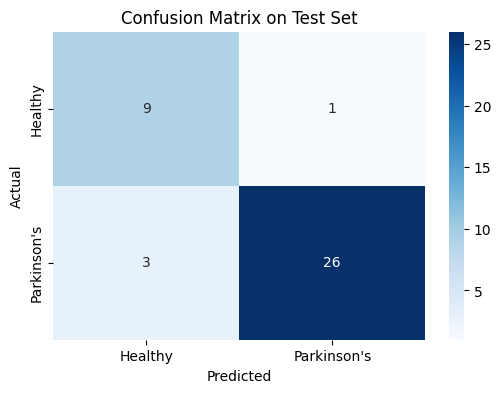

In [12]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Healthy", "Parkinson's"], yticklabels=["Healthy", "Parkinson's"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix on Test Set")
plt.show()


In [13]:
columns = X.columns.tolist()

def predict_with_threshold(model, scaler, input_data):
    input_df = pd.DataFrame([input_data], columns=columns)
    input_scaled = scaler.transform(input_df)
    prob = model.predict_proba(input_scaled)[0][1]

    if prob > 0.55:
        return f"🟢 Positive: Likely has Parkinson's disease (probability: {prob:.4f})"
    elif 0.45 <= prob <= 0.55:
        return f"🟡 Uncertain: Borderline case (probability: {prob:.4f}), further tests advised"
    else:
        return f"🔴 Negative: Likely healthy (probability: {prob:.4f})"


In [14]:
with open("parkinsons_model.pkl", "wb") as f:
    pickle.dump(model, f)

with open("parkinsons_scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)


In [15]:
# Simulated test cases for Parkinson's prediction
positive_input = [140.0, 170.0, 110.0, 0.01, 0.00007, 0.008, 0.009, 0.02, 0.05, 0.4,
                  0.02, 0.03, 0.04, 0.06, 0.02, 20.0, 0.55, 0.65, -4.0, 0.2, 2.0, 0.12]

negative_input = [150.0, 160.0, 110.0, 0.003, 0.00001, 0.002, 0.003, 0.006, 0.03, 0.2,
                  0.01, 0.015, 0.02, 0.025, 0.005, 26.0, 0.45, 0.55, -5.0, 0.1, 1.8, 0.08]

uncertain_input = [145.0, 155.0, 108.0, 0.005, 0.00003, 0.004, 0.005, 0.01, 0.04, 0.3,
                   0.015, 0.02, 0.03, 0.04, 0.01, 23.0, 0.50, 0.60, -4.5, 0.15, 1.9, 0.10]



In [16]:
print("✅ Positive Case Test:")
print(predict_with_threshold(model, scaler, positive_input))

print("\n✅ Negative Case Test:")
print(predict_with_threshold(model, scaler, negative_input))

print("\n✅ Uncertain Case Test:")
print(predict_with_threshold(model, scaler, uncertain_input))


✅ Positive Case Test:
🟢 Positive: Likely has Parkinson's disease (probability: 0.8300)

✅ Negative Case Test:
🟡 Uncertain: Borderline case (probability: 0.5300), further tests advised

✅ Uncertain Case Test:
🟢 Positive: Likely has Parkinson's disease (probability: 0.7500)
